In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from reducer import*
from ensemble import*
from super_learner import*
from TLP import TLP
from scipy.stats import t


data_fn = 'longitudinal_data/220416wave2_3.csv'
title = 'longitudinal_'
df = pd.read_csv(data_fn)

cols = df.columns

print(cols)

def threshold_graph(digraph, threshold):
    cols = digraph.nodes
    # to dense
    cm = nx.adjacency_matrix(digraph).todense()

    plt.hist(cm.ravel().T, bins=20)
    plt.show()

    # threshold
    cm[cm < threshold] = 0.0
    cm[cm >= threshold] = 1.0
    
    # back to graph 
    df_cm = pd.DataFrame(cm, index =cols,
                  columns = cols)
    digraph = nx.from_pandas_adjacency(df_cm.T, create_using=nx.DiGraph())
    
    return digraph

def get_rents_children(graph, var):
    rents = list(graph.predecessors(var))
    children = list(graph.successors(var))
    return rents, children


    
def plot_subbgraph(G, variables, size=(10, 8), subgraph_name='name', plot_adj=False, threshold=None):
    H = nx.subgraph(G, variables)
    variables = H.nodes

    cmap = plt.get_cmap('cool')
    #     pos = nx.spring_layout(H)
    edge_widths = [w for (*edge, w) in H.edges.data('weight')]
    edge_colors = [w for (*edge, w) in H.edges.data('weight')]
    vmin = min(edge_colors)
    vmax = max(edge_colors)

    plt.figure(figsize=size)
    nx.draw_shell(H, width=edge_widths, with_labels=True, vmin=vmin, vmax=vmax,
                  node_color='lightgreen', edge_color='k',
                  node_size=250, connectionstyle='arc3, rad=.15')
    plt.savefig('results/' + subgraph_name + '.png', dpi=150)
    plt.show()

    if plot_adj:
        cmap = plt.get_cmap('bone')
        cm = nx.adjacency_matrix(H).todense()
        df_cm = pd.DataFrame(cm, index=variables,
                             columns=variables)

        plt.figure(figsize=(23, 18))
        sns.set(font_scale=2.0)
        sns.heatmap(df_cm.clip(lower=0.4, upper=0.7), cbar=False, linewidths=2, vmin=0.3, vmax=0.8, cmap=cmap,
                    center=0.2)
        plt.xlabel('Effects')
        plt.ylabel('Causes')
        name = 'Adjacency Graph w/ Confidence Threshold: {}'.format(threshold)
        plt.tight_layout()
        plt.savefig('results/' + subgraph_name + '_adj.png', dpi=150)
        plt.title(name)
        plt.show()

vars_correct = ['W2_Risk_total', 'W2_Hygiene_total', 'W2_Dep_Total','W2_GAD_Total', 'W2_Loneliness_Total',
               'W3_Dep_Total','W3_GAD_Total']
vars_divvo = [10.0, 11.0, 9, 7, 3, 9, 7]

for i, var in enumerate(vars_correct):
    df[var] = df[var] / vars_divvo[i]
    
df.describe()    

Index(['W2_Age_year', 'W2_Gender', 'W2_Relationship', 'W2_Keyworker',
       'W2_Adults_household', 'W2_Children_household', 'W2_Change_Income',
       'W2_Chronic_illness_self', 'W2_Pregnant', 'W2_COVID19_anxiety',
       'W2_RISK_1month', 'W2_Risk_total', 'W2_Hygiene_total', 'W2_Dep_Total',
       'W2_GAD_Total', 'W2_Loneliness_Total', 'W2_Attach_Style',
       'W3_Dep_Total', 'W3_GAD_Total'],
      dtype='object')


,W2_Age_year,W2_Gender,W2_Relationship,W2_Keyworker,W2_Adults_household,W2_Children_household,W2_Change_Income,W2_Chronic_illness_self,W2_Pregnant,W2_COVID19_anxiety,W2_RISK_1month,W2_Risk_total,W2_Hygiene_total,W2_Dep_Total,W2_GAD_Total,W2_Loneliness_Total,W2_Attach_Style,W3_Dep_Total,W3_GAD_Total
count,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000
mean,51.563128,1.464804,2.339665,0.258101,1.985475,0.301676,-8.775419,0.250279,0.014525,60.463687,38.543017,1.248827,4.282275,0.519801,0.567279,1.546369,2.366480,0.560770,0.577973
std,14.498792,0.531598,2.141719,0.437834,0.885384,0.698790,24.421675,0.433416,0.152574,26.098646,24.311138,0.560956,0.664297,0.613230,0.720891,0.590592,1.248621,0.674963,0.740940
min,18.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-100.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,40.500000,1.000000,1.000000,0.000000,1.000000,0.000000,-19.000000,0.000000,0.000000,48.000000,18.000000,1.000000,3.909091,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
50%,53.000000,1.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,65.000000,40.000000,1.000000,4.454545,0.333333,0.285714,1.333333,2.000000,0.333333,0.285714
75%,63.000000,2.000000,3.000000,1.000000,2.000000,0.000000,0.500000,0.500000,0.000000,81.000000,52.000000,1.200000,4.863636,0.777778,0.857143,2.000000,4.000000,0.888889,1.000000
max,88.000000,5.000000,11.000000,1.000000,8.000000,5.000000,100.000000,1.000000,2.000000,100.000000,100.000000,5.000000,5.000000,3.000000,3.000000,3.000000,4.000000,3.000000,3.000000


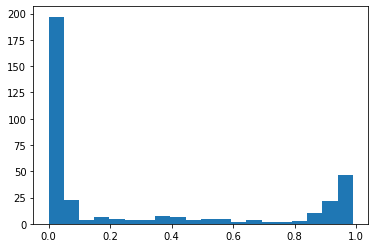

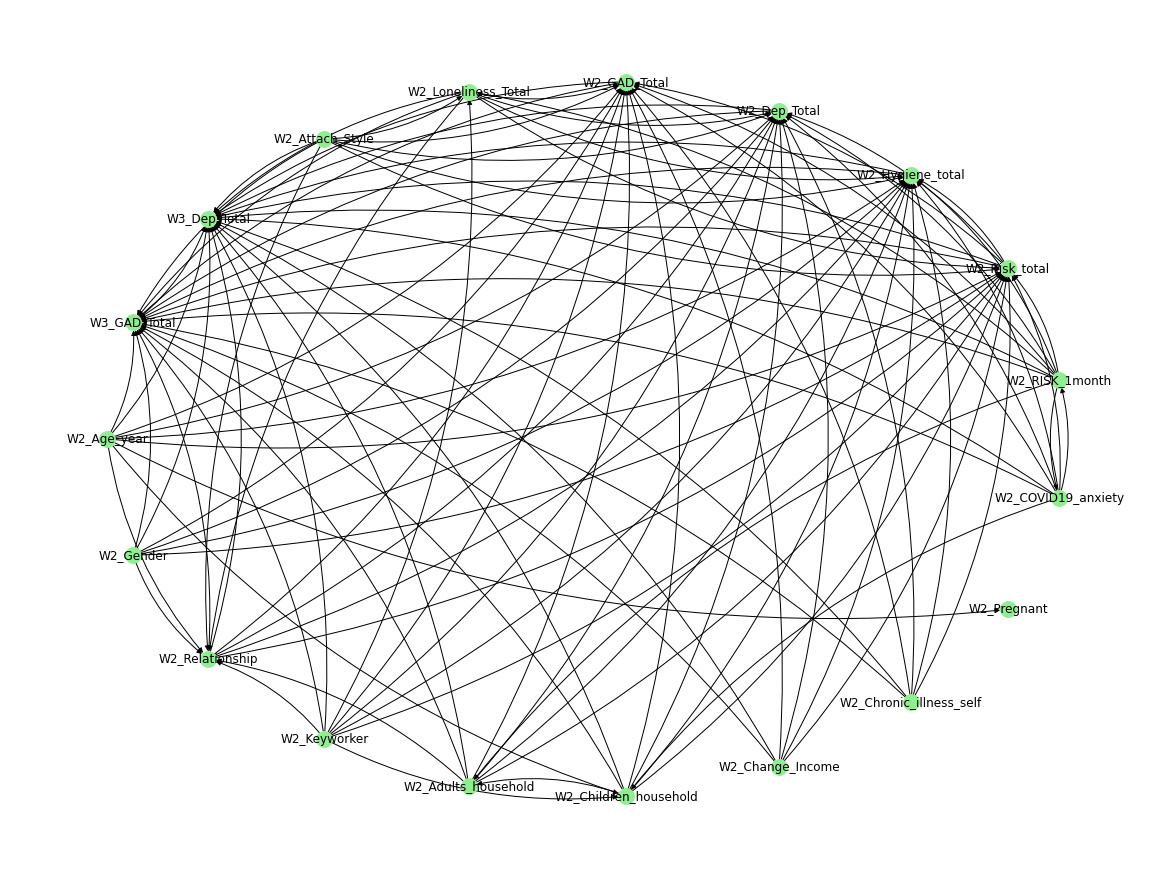

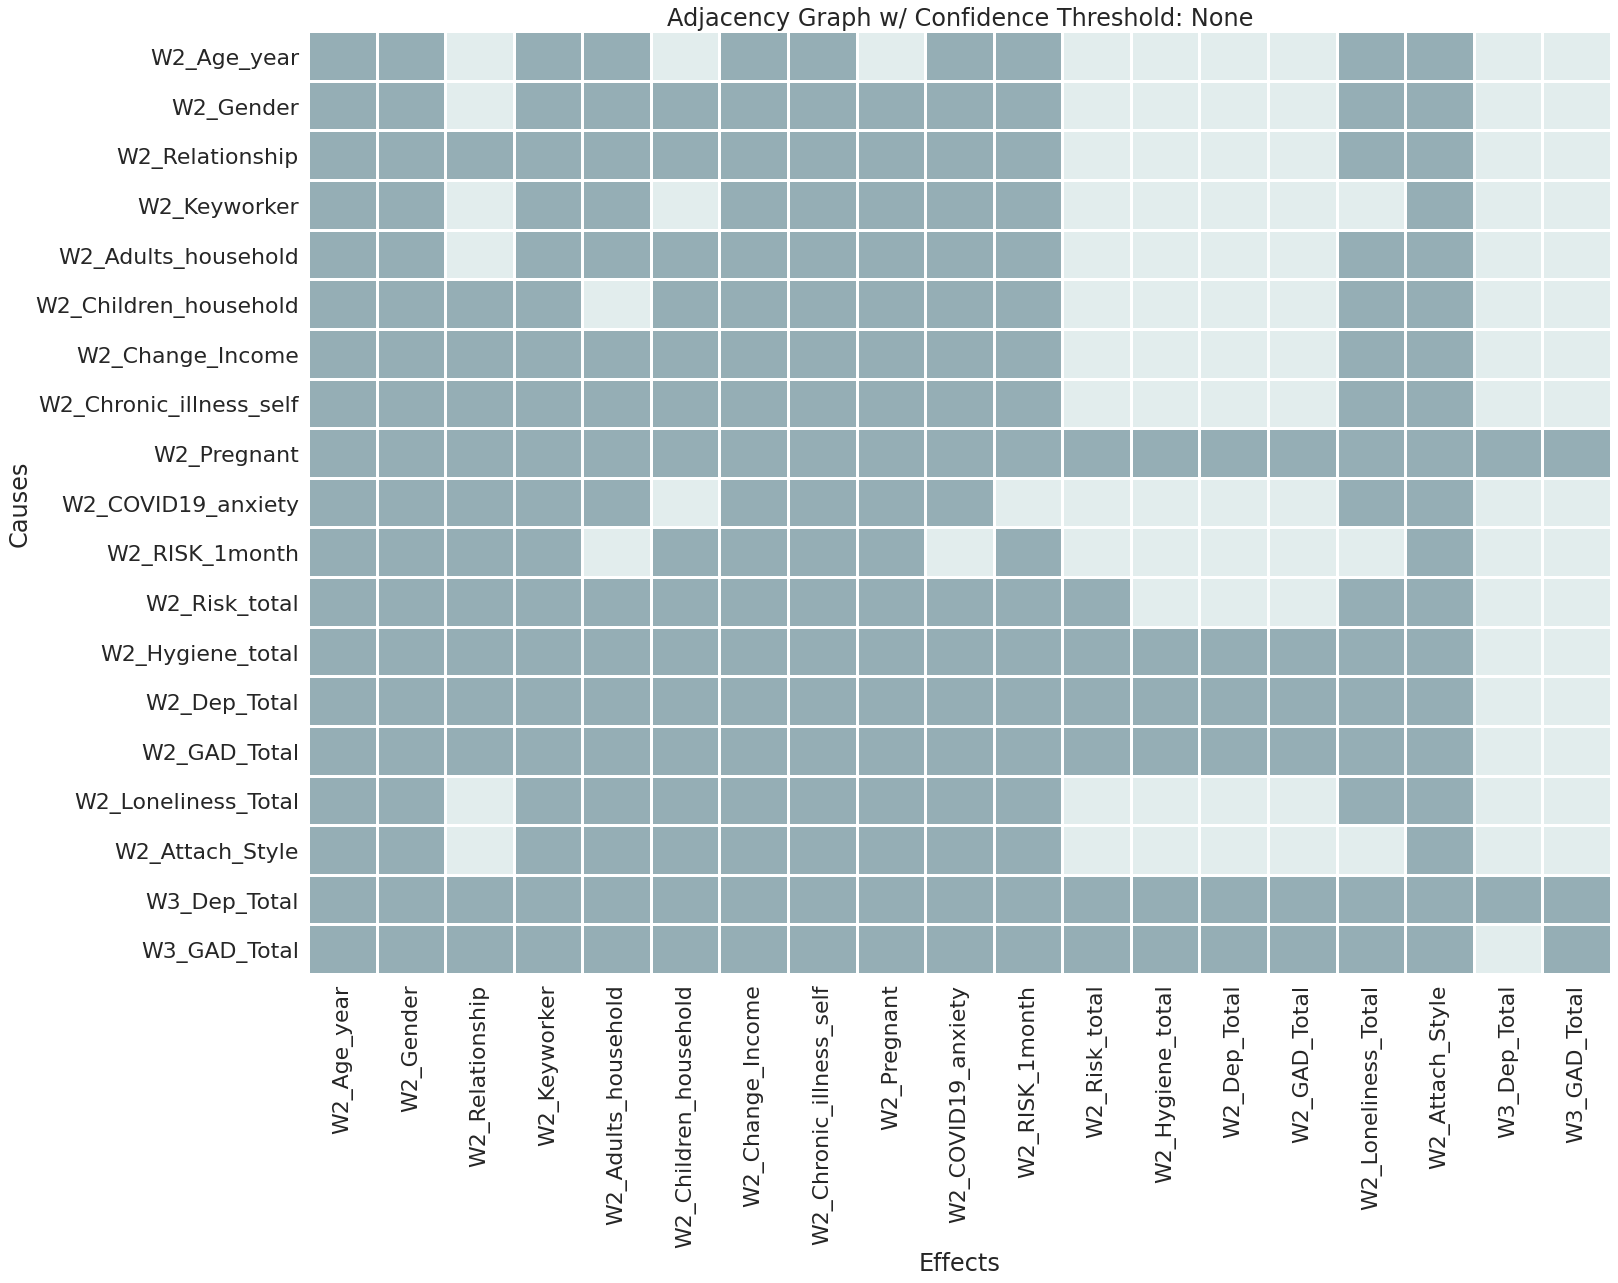

In [2]:
graph_name = 'longitudinal_constrained_1var_attachment_T2-T3_lr_0.01_dagloss_True_dagpen_0.05_numruns_30.gml'
graph_name_short = '.'.join(graph_name.split('.')[:-1])

output = nx.read_gml("graphs/" + graph_name, destringizer=int)

threshold = 0.5
G_thresh = threshold_graph(output, threshold=threshold)
plot_subbgraph(G=G_thresh, variables=cols, subgraph_name=title+graph_name_short + '_all_{}'.format(threshold), size=(16,12), plot_adj=True)

In [3]:

glen = 1
while glen > 0:
    cycle_list = list(nx.simple_cycles(G_thresh))
    print(cycle_list)
    glen = len(cycle_list)
    if glen == 0:
        break
    else:
        G_thresh.remove_edge(cycle_list[0][0], cycle_list[0][1])

[['W2_RISK_1month', 'W2_COVID19_anxiety']]
[]


In [4]:
    
outcomes = ['W3_Dep_Total', 'W3_GAD_Total']
causes = ['W2_Attach_Style']


scale_ranges = [[0, 3], [0, 3]]

k=10

tl_ests = []
tl_ses = []
tl_ps = []

naives_effects = []
naives_ses = []
naives_ps = []

df['W2_Attach_Style'] -= 1

for i, ys in enumerate(outcomes):
    
    outcome_min, outcome_max = scale_ranges[i][0], scale_ranges[i][1]
    
    tl_lr_result = pd.DataFrame()
    tl_lr_result['outcome'] = [ys]
    
    tl_result = pd.DataFrame()
    tl_result['outcome'] = [ys]

    rd, confs, precs = reducer(G_thresh, causes, [ys],  remove_precision=True, project_causes=True, project_confs=True)
    print('outcome: ', ys, '. Confounders:', confs, '. Precisions:', precs, '\n')
    
    if len(confs)==0:
        confs = set(['W2_Gender'])
    
    est_dict_Q = ['Elastic', 'BR', 'SV', 'LR', 'RF', 'MLP', 'AB', 'poly']
    est_dict_G = ['LR', 'NB', 'MLP','SV', 'poly', 'RF','AB']
    
    outcome_type = 'reg'   # cls or reg

    group_comparisons =[[1,0],[2,0],[3,0]]  # comparison in list format with 'group A [vs] reference_group'
    
    k = 8  # number of folds for SL training

    # initialise TLP object
    tlp = TLP(df, cause='W2_Attach_Style', outcome=ys, confs=list(confs),
              precs=list(precs), outcome_type=outcome_type, Q_learners=est_dict_Q, G_learners=est_dict_G,
             outcome_upper_bound= scale_ranges[i][1], outcome_lower_bound=scale_ranges[i][0])


    # fit SuperLearners
    all_preds_Q, gts_Q, all_preds_G, gts_G = tlp.fit(k=k, standardized_outcome=False, calibrationQ=True, calibrationG=False)

    # 'do' targeted learning
    pre_update_effects, post_update_effects, ses, ps = tlp.target_multigroup(group_comparisons=group_comparisons)
    
    tl_ests.append(post_update_effects)
    tl_ses.append(ses)
    tl_ps.append(ps)
    
    naive_effects = {}
    naive_ses = {}
    naive_ps = {}
    for group_comparison in group_comparisons:
        group_a = group_comparison[0]
        group_ref = group_comparison[1]
        
        data_a = (df[df.W2_Attach_Style == group_a][ys] - scale_ranges[i][0]) / (scale_ranges[i][1] - scale_ranges[i][0])
        data_ref = (df[df.W2_Attach_Style == group_ref][ys] - scale_ranges[i][0]) / (scale_ranges[i][1] - scale_ranges[i][0])
        na = len(data_a)
        nref = len(data_ref)
        naive = data_a.mean() - data_ref.mean()
        data_a_se = np.std(data_a, ddof=1) / (np.sqrt(na))
        data_ref_se = np.std(data_ref, ddof=1) / (np.sqrt(nref))
        diff_se = np.sqrt(data_a_se**2 + data_ref_se**2)
        
        p = 2 * (1 - t.cdf(np.abs(naive) /diff_se, na+nref))
        
        upper, lower = naive + 1.96*diff_se, naive - 1.96*diff_se
        
        naive_effects[str(group_comparison)] = naive
        naive_ses[str(group_comparison)] = (diff_se, upper, lower)
        naive_ps[str(group_comparison)] = p
        
    naives_effects.append(naive_effects)
    naives_ses.append(naive_ses)
    naives_ps.append(naive_ps)
        
        
        

    
   

  0%|          | 0/11 [00:00<?, ?it/s]

outcome:  W3_Dep_Total . Confounders: set() . Precisions: {'W2_Keyworker', 'W2_Change_Income', 'W2_Adults_household', 'W2_Gender', 'W2_Children_household', 'W2_COVID19_anxiety', 'W2_Chronic_illness_self', 'W2_Age_year', 'W2_RISK_1month', 'W2_Pregnant'} 

Training Q Learners...


  0%|          | 0/7 [00:00<?, ?it/s]

Generating QAW Predictions 
Bounding outcome predictions.
Training G Learners...


100%|██████████| 7/7 [00:00<00:00, 11.50it/s]


Generating G Predictions 
SuperLearner Training Completed.
Generating predictions for counterfactual outcomes...


  0%|          | 0/11 [00:00<?, ?it/s]

Computing group differences between counterfactual outcomes...
Computing clever covariates...
Estimating fluctuation parameters...
Updating initial counterfactual predictions...
Deriving the Influence Function, standard error, CI bounds and p-values
outcome:  W3_GAD_Total . Confounders: set() . Precisions: {'W2_Keyworker', 'W2_Change_Income', 'W2_Adults_household', 'W2_Gender', 'W2_Children_household', 'W2_COVID19_anxiety', 'W2_Chronic_illness_self', 'W2_Age_year', 'W2_RISK_1month', 'W2_Pregnant'} 

Training Q Learners...


  0%|          | 0/7 [00:00<?, ?it/s]

Generating QAW Predictions 
Bounding outcome predictions.
Training G Learners...


100%|██████████| 7/7 [00:00<00:00, 10.69it/s]


Generating G Predictions 
SuperLearner Training Completed.
Generating predictions for counterfactual outcomes...
Computing group differences between counterfactual outcomes...
Computing clever covariates...
Estimating fluctuation parameters...
Updating initial counterfactual predictions...
Deriving the Influence Function, standard error, CI bounds and p-values


In [10]:
results = []
for i, outcome in enumerate(outcomes):
    result = pd.DataFrame()
    result['outcome'] = [outcome]
    
    for group_comparison in group_comparisons:
        result[str(group_comparison) + '_p'] = np.array([tl_ps[i][str(group_comparison)]])
        
        result[str(group_comparison) + '_se'] = np.array([tl_ses[i][str(group_comparison)][0]])
        result[str(group_comparison) + '_ub'] = np.array([tl_ses[i][str(group_comparison)][1]])
        result[str(group_comparison) + '_lb'] = np.array([tl_ses[i][str(group_comparison)][2]])
        
        result[str(group_comparison) + '_effect'] = np.array([tl_ests[i][str(group_comparison)]])
        result[str(group_comparison) + '_naive_effect'] = np.array([naives_effects[i][str(group_comparison)]])
        result[str(group_comparison) + '_naive_se'] = np.array([naives_ses[i][str(group_comparison)][0]])
        result[str(group_comparison) + '_naive_ub'] = np.array([naives_ses[i][str(group_comparison)][1]])
        result[str(group_comparison) + '_naive_lb'] = np.array([naives_ses[i][str(group_comparison)][2]])
        result[str(group_comparison) + '_naive_p'] = np.array([naives_ps[i][str(group_comparison)]])
        
    results.append(result)

results = pd.concat(results)


results.to_csv('tl_results/targeted_learning_results_longitudinal_1var_attach.csv', index=False) 

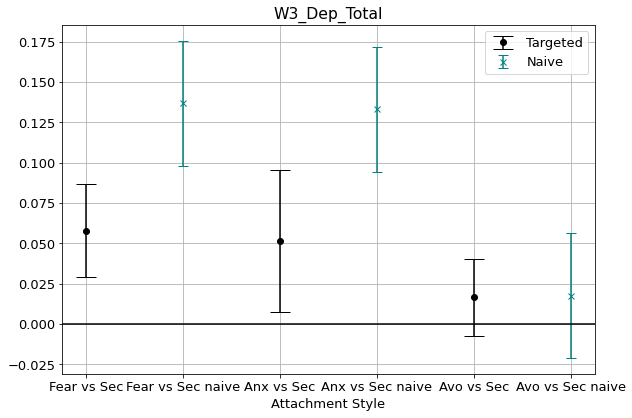

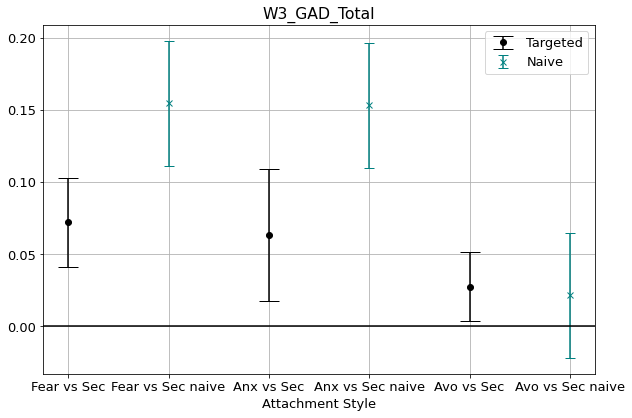

In [11]:

plt.rcParams.update({'font.size': 13})


for outcome in outcomes:
    
    est_2_1 = results[results.outcome == outcome]['[1, 0]_effect'].values
    err_2_1 = 1.96 * results[results.outcome == outcome]['[1, 0]_se'].values
    
    est_3_1 = results[results.outcome == outcome]['[2, 0]_effect'].values
    err_3_1 = 1.96 * results[results.outcome == outcome]['[2, 0]_se'].values
    
    est_4_1 = results[results.outcome == outcome]['[3, 0]_effect'].values
    err_4_1 = 1.96 * results[results.outcome == outcome]['[3, 0]_se'].values

    
    est_2_1_naive = results[results.outcome == outcome]['[1, 0]_naive_effect'].values
    err_2_1_naive = 1.96 * results[results.outcome == outcome]['[1, 0]_naive_se'].values
    
    est_3_1_naive = results[results.outcome == outcome]['[2, 0]_naive_effect'].values
    err_3_1_naive = 1.96 * results[results.outcome == outcome]['[1, 0]_naive_se'].values
    
    est_4_1_naive = results[results.outcome == outcome]['[3, 0]_naive_effect'].values
    err_4_1_naive = 1.96 * results[results.outcome == outcome]['[1, 0]_naive_se'].values
    
    
    
    plt.figure(figsize=(9,6))
    plt.title(outcome)
    plt.errorbar(x=['Fear vs Sec'], y=est_2_1, yerr=err_2_1, capsize=10, fmt='o', color='k', label='Targeted')
    plt.errorbar(x=['Fear vs Sec naive'], y=est_2_1_naive, yerr=err_2_1_naive, capsize=5, fmt='x', color='teal', label='Naive')
    
    plt.errorbar(x=['Anx vs Sec'], y=est_3_1, yerr=err_3_1, capsize=10, fmt='o', color='k')
    plt.errorbar(x=['Anx vs Sec naive'], y=est_3_1_naive, yerr=err_3_1_naive, capsize=5, fmt='x', color='teal')
    
    plt.errorbar(x=['Avo vs Sec'], y=est_4_1, yerr=err_4_1, capsize=10, fmt='o', color='k')
    plt.errorbar(x=['Avo vs Sec naive'], y=est_4_1_naive, yerr=err_4_1_naive, capsize=5, fmt='x', color='teal')
    
    plt.xlabel('Attachment Style')
    plt.axhline(y = 0, color = 'k', linestyle = '-')
    plt.grid()
    plt.tight_layout()
    plt.legend()
    plt.savefig('tl_results/' + outcome+'_targeted_comparison_longitudinal.png', dpi=200)

    plt.show()

In [12]:
#################### WITH MEDIATION THROUGH T2 OUTCOMES (blocks indirect effect) ##################### 



    
    
        
outcomes = ['W3_Dep_Total', 'W3_GAD_Total']
causes = ['W2_Attach_Style']


scale_ranges = [[0, 3], [0, 3]]

k=10

tl_ests = []
tl_ses = []
tl_ps = []

naives_effects = []
naives_ses = []
naives_ps = []

# df['W2_Attach_Style'] -= 1  # already done above

for i, ys in enumerate(outcomes):
    
    outcome_min, outcome_max = scale_ranges[i][0], scale_ranges[i][1]
    
    tl_lr_result = pd.DataFrame()
    tl_lr_result['outcome'] = [ys]
    
    tl_result = pd.DataFrame()
    tl_result['outcome'] = [ys]

    rd, confs, precs = reducer(G_thresh, causes, [ys],  remove_precision=True, project_causes=True, project_confs=True)
    print('outcome: ', ys, '. Confounders:', confs, '. Precisions:', precs, '\n')
    
    if len(confs)==0:
        confs = set(['W2_Gender'])
        
    if ys == 'W3_Dep_Total':
        mediator = ['W2_Dep_Total']
        
    elif ys == 'W3_GAD_Total':
        mediator = ['W2_GAD_Total']
        
    precs = set(precs) | set(confs) | set(mediator)  # add mediator to model
    
    
    est_dict_Q = ['Elastic', 'BR', 'SV', 'LR', 'RF', 'MLP', 'AB', 'poly']
    est_dict_G = ['LR', 'NB', 'MLP','SV', 'poly', 'RF','AB']
    
    outcome_type = 'reg'   # cls or reg

    group_comparisons =[[1,0],[2,0],[3,0]]  # comparison in list format with 'group A [vs] reference_group'
    
    k = 8  # number of folds for SL training

    # initialise TLP object
    tlp = TLP(df, cause='W2_Attach_Style', outcome=ys, confs=list(confs),
              precs=list(precs), outcome_type=outcome_type, Q_learners=est_dict_Q, G_learners=est_dict_G,
             outcome_upper_bound= scale_ranges[i][1], outcome_lower_bound=scale_ranges[i][0])


    # fit SuperLearners
    all_preds_Q, gts_Q, all_preds_G, gts_G = tlp.fit(k=k, standardized_outcome=False, calibrationQ=True, calibrationG=False)

    # 'do' targeted learning
    pre_update_effects, post_update_effects, ses, ps = tlp.target_multigroup(group_comparisons=group_comparisons)
    
    tl_ests.append(post_update_effects)
    tl_ses.append(ses)
    tl_ps.append(ps)
    
    naive_effects = {}
    naive_ses = {}
    naive_ps = {}
    for group_comparison in group_comparisons:
        group_a = group_comparison[0]
        group_ref = group_comparison[1]
        
        data_a = (df[df.W2_Attach_Style == group_a][ys] - scale_ranges[i][0]) / (scale_ranges[i][1] - scale_ranges[i][0])
        data_ref = (df[df.W2_Attach_Style == group_ref][ys] - scale_ranges[i][0]) / (scale_ranges[i][1] - scale_ranges[i][0])
        na = len(data_a)
        nref = len(data_ref)
        naive = data_a.mean() - data_ref.mean()
        data_a_se = np.std(data_a, ddof=1) / (np.sqrt(na))
        data_ref_se = np.std(data_ref, ddof=1) / (np.sqrt(nref))
        diff_se = np.sqrt(data_a_se**2 + data_ref_se**2)
        
        p = 2 * (1 - t.cdf(np.abs(naive) /diff_se, na+nref))
        
        upper, lower = naive + 1.96*diff_se, naive - 1.96*diff_se
        
        naive_effects[str(group_comparison)] = naive
        naive_ses[str(group_comparison)] = (diff_se, upper, lower)
        naive_ps[str(group_comparison)] = p
        
    naives_effects.append(naive_effects)
    naives_ses.append(naive_ses)
    naives_ps.append(naive_ps)
        
        
        

    
   


 36%|███▋      | 4/11 [00:00<00:00, 39.73it/s]

outcome:  W3_Dep_Total . Confounders: set() . Precisions: {'W2_Keyworker', 'W2_Change_Income', 'W2_Adults_household', 'W2_Gender', 'W2_Children_household', 'W2_COVID19_anxiety', 'W2_Chronic_illness_self', 'W2_Age_year', 'W2_RISK_1month', 'W2_Pregnant'} 

Training Q Learners...


  0%|          | 0/7 [00:00<?, ?it/s]

Generating QAW Predictions 
Bounding outcome predictions.
Training G Learners...


100%|██████████| 7/7 [00:00<00:00, 11.27it/s]


Generating G Predictions 
SuperLearner Training Completed.
Generating predictions for counterfactual outcomes...


 36%|███▋      | 4/11 [00:00<00:00, 38.32it/s]

Computing group differences between counterfactual outcomes...
Computing clever covariates...
Estimating fluctuation parameters...
Updating initial counterfactual predictions...
Deriving the Influence Function, standard error, CI bounds and p-values
outcome:  W3_GAD_Total . Confounders: set() . Precisions: {'W2_Keyworker', 'W2_Change_Income', 'W2_Adults_household', 'W2_Gender', 'W2_Children_household', 'W2_COVID19_anxiety', 'W2_Chronic_illness_self', 'W2_Age_year', 'W2_RISK_1month', 'W2_Pregnant'} 

Training Q Learners...


  0%|          | 0/7 [00:00<?, ?it/s]

Generating QAW Predictions 
Bounding outcome predictions.
Training G Learners...


100%|██████████| 7/7 [00:00<00:00, 11.26it/s]


Generating G Predictions 
SuperLearner Training Completed.
Generating predictions for counterfactual outcomes...
Computing group differences between counterfactual outcomes...
Computing clever covariates...
Estimating fluctuation parameters...
Updating initial counterfactual predictions...
Deriving the Influence Function, standard error, CI bounds and p-values


In [13]:
results = []
for i, outcome in enumerate(outcomes):
    result = pd.DataFrame()
    result['outcome'] = [outcome]
    
    for group_comparison in group_comparisons:
        result[str(group_comparison) + '_p'] = np.array([tl_ps[i][str(group_comparison)]])
        
        result[str(group_comparison) + '_se'] = np.array([tl_ses[i][str(group_comparison)][0]])
        result[str(group_comparison) + '_ub'] = np.array([tl_ses[i][str(group_comparison)][1]])
        result[str(group_comparison) + '_lb'] = np.array([tl_ses[i][str(group_comparison)][2]])
        
        result[str(group_comparison) + '_effect'] = np.array([tl_ests[i][str(group_comparison)]])
        result[str(group_comparison) + '_naive_effect'] = np.array([naives_effects[i][str(group_comparison)]])
        result[str(group_comparison) + '_naive_se'] = np.array([naives_ses[i][str(group_comparison)][0]])
        result[str(group_comparison) + '_naive_ub'] = np.array([naives_ses[i][str(group_comparison)][1]])
        result[str(group_comparison) + '_naive_lb'] = np.array([naives_ses[i][str(group_comparison)][2]])
        result[str(group_comparison) + '_naive_p'] = np.array([naives_ps[i][str(group_comparison)]])
        
    results.append(result)

results = pd.concat(results)


results.to_csv('tl_results/targeted_learning_results_longitudinal_1var_attach_withMediator.csv', index=False) 


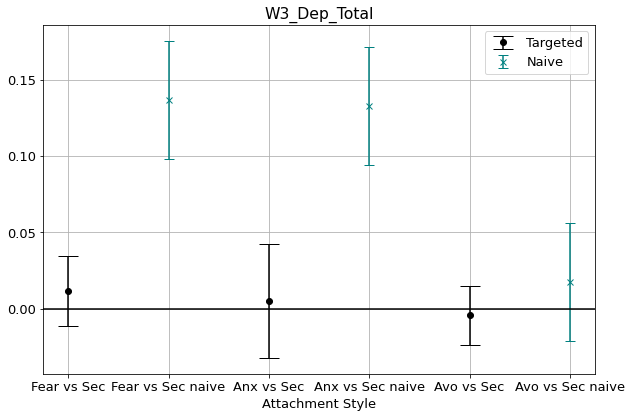

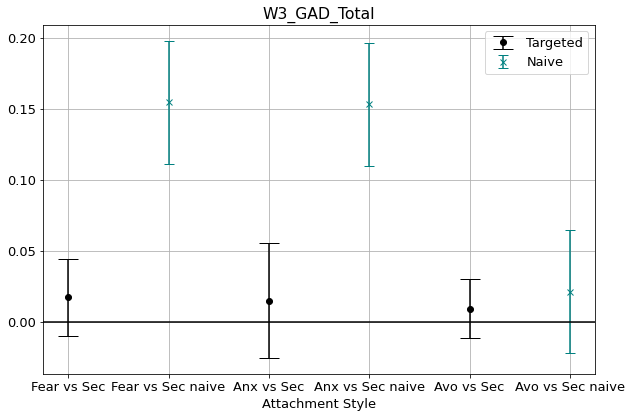

In [14]:

plt.rcParams.update({'font.size': 13})


for outcome in outcomes:
    
    est_2_1 = results[results.outcome == outcome]['[1, 0]_effect'].values
    err_2_1 = 1.96 * results[results.outcome == outcome]['[1, 0]_se'].values
    
    est_3_1 = results[results.outcome == outcome]['[2, 0]_effect'].values
    err_3_1 = 1.96 * results[results.outcome == outcome]['[2, 0]_se'].values
    
    est_4_1 = results[results.outcome == outcome]['[3, 0]_effect'].values
    err_4_1 = 1.96 * results[results.outcome == outcome]['[3, 0]_se'].values

    
    est_2_1_naive = results[results.outcome == outcome]['[1, 0]_naive_effect'].values
    err_2_1_naive = 1.96 * results[results.outcome == outcome]['[1, 0]_naive_se'].values
    
    est_3_1_naive = results[results.outcome == outcome]['[2, 0]_naive_effect'].values
    err_3_1_naive = 1.96 * results[results.outcome == outcome]['[1, 0]_naive_se'].values
    
    est_4_1_naive = results[results.outcome == outcome]['[3, 0]_naive_effect'].values
    err_4_1_naive = 1.96 * results[results.outcome == outcome]['[1, 0]_naive_se'].values
    
    
    
    plt.figure(figsize=(9,6))
    plt.title(outcome)
    plt.errorbar(x=['Fear vs Sec'], y=est_2_1, yerr=err_2_1, capsize=10, fmt='o', color='k', label='Targeted')
    plt.errorbar(x=['Fear vs Sec naive'], y=est_2_1_naive, yerr=err_2_1_naive, capsize=5, fmt='x', color='teal', label='Naive')
    
    plt.errorbar(x=['Anx vs Sec'], y=est_3_1, yerr=err_3_1, capsize=10, fmt='o', color='k')
    plt.errorbar(x=['Anx vs Sec naive'], y=est_3_1_naive, yerr=err_3_1_naive, capsize=5, fmt='x', color='teal')
    
    plt.errorbar(x=['Avo vs Sec'], y=est_4_1, yerr=err_4_1, capsize=10, fmt='o', color='k')
    plt.errorbar(x=['Avo vs Sec naive'], y=est_4_1_naive, yerr=err_4_1_naive, capsize=5, fmt='x', color='teal')
    
    plt.xlabel('Attachment Style')
    plt.axhline(y = 0, color = 'k', linestyle = '-')
    plt.grid()
    plt.tight_layout()
    plt.legend()
    plt.savefig('tl_results/' + outcome+'_targeted_comparison_longitudinal_withMediator.png', dpi=200)

    plt.show()